K=256, CelebAデータセットtraining train size112*80

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 256
# VQ-VAE
VQ_epoch = 20 # epoch
# default
embedding_dim = 64 # D
num_embeddings = 256 # K
num_hiddens = 128 # out_channels
num_residual_hiddens = 32 # residualのout_channels
num_residual_layers = 2 # residualの繰り返し数
commitment_cost = 0.25
decay = 0 # EMA使うか
learning_rate = 1e-3

img_size = (56*2, 40*2) # 中心からimg_size*img_size
in_channels=color=3 # カラー画像
img_num = 25 # 画像の枚数
folder = './VQ_VAE' # 保存場所
os.makedirs(folder, exist_ok=True)

# dataset
# train 162770 test 19962 valid 19867 all 202599 , size 3, 218, 178
training_data = datasets.CelebA(root="~/b2022_kodai/data", download=True, split= 'train', 
                                  transform=transforms.Compose([
                                    transforms.CenterCrop((img_size[0], img_size[1])),
                                    # transforms.Resize(img_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0)) # torchvision.transforms.Normalize(mean, std, inplace=False)
                                  ])) # テンソル　正規化 

validation_data = datasets.CelebA(root="~/b2022_kodai/data",  download=True, split= 'valid',# target_type='identity',
                                  transform=transforms.Compose([
                                    transforms.CenterCrop((img_size[0], img_size[1])),
                                    # transforms.Resize(img_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

training_loader = DataLoader(training_data, batch_size=batch_size, drop_last=True, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, drop_last=True, shuffle=True, pin_memory=True)

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost): # K, D, beta
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim) # torch.nn.Embedding(num_embeddings, embedding_dim, padding_idx=None, max_norm=None, norm_type=2.0, scale_grad_by_freq=False, sparse=False, _weight=None, device=None, dtype=None)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings) # 一様分布
        self._commitment_cost = commitment_cost # 0.25 ?

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous() # 軸の入れ替え　参照ではない
        input_shape = inputs.shape
        
        # Flatten input (16384, 64)
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances 2乗距離 (16384, 512)
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) + torch.sum(self._embedding.weight**2, dim=1) - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding　One-hot表現
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) # 最短距離のindex
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1) # Tensor.scatter_(dim, index, src, reduce=None)
        
        # Quantize and unflatten 埋め込みベクトルに置き換え
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        quantized2 = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs) # 第2項
        q_latent_loss = F.mse_loss(quantized, inputs.detach()) # 第3項
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach() # 勾配の切り離し
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, distances ,encoding_indices, encodings

class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens): # 128, 128, 32
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels, out_channels=num_residual_hiddens, kernel_size=3, stride=1, padding=1, bias=False), # チャンネル数32に減らす
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens, out_channels=num_hiddens, kernel_size=1, stride=1, bias=False) # チャンネル数128に戻す
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):# 128, 128, 2, 32
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens) for _ in range(self._num_residual_layers)]) # residual 2回

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens): # 3, 128, 2, 32
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=num_hiddens//2, kernel_size=4, stride=2, padding=1) # チャンネル数64に増やす サイズ1/2
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2, out_channels=num_hiddens, kernel_size=4, stride=2, padding=1) # チャンネル数128に増やす サイズ1/2
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens, out_channels=num_hiddens, kernel_size=3, stride=1, padding=1) # 維持
        self._residual_stack = ResidualStack(in_channels=num_hiddens, num_hiddens=num_hiddens, num_residual_layers=num_residual_layers, num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        return self._residual_stack(x)

class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens): # D, 128, 2, 32
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=num_hiddens, kernel_size=3, stride=1, padding=1) # D, 128
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens, num_hiddens=num_hiddens, num_residual_layers=num_residual_layers, num_residual_hiddens=num_residual_hiddens) # 128, 128, 2, 32
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, out_channels=num_hiddens//2, kernel_size=4, stride=2, padding=1) # 128, 64 サイズ2倍
        # ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None)
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, out_channels=color, kernel_size=4, stride=2, padding=1) # 64, channel数 サイズ2倍(元のサイズ)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)
        x = F.relu(x)
        
        return self._conv_trans_2(x)

class Model(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        
        self._encoder = Encoder(in_channels, num_hiddens, num_residual_layers, num_residual_hiddens) # 3, 128, 2, 32
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, out_channels=embedding_dim, kernel_size=1, stride=1) # 128, 64
        # if decay > 0.0:
        #     self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
        #                                       commitment_cost, decay)
        # else:
        self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost) # K, D, beta
        self._decoder = Decoder(embedding_dim, num_hiddens, num_residual_layers, num_residual_hiddens) # D, 128, 2, 32

    def forward(self, x):
        z = self._encoder(x) # channel=128, size=1/4
        z = self._pre_vq_conv(z) # channel=64 埋め込みベクトルの次元にする
        loss, quantized, perplexity, distances, encoding_indices, encodings = self._vq_vae(z) # 埋め込みベクトルに置き換え
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity, distances, encoding_indices, encodings

model = Model(in_channels, num_hiddens, num_residual_layers, num_residual_hiddens, num_embeddings, embedding_dim, commitment_cost, decay).to(device) # モデル作成
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)
model.train()
train_recon_error = [] # エポック毎にMSEを記録

print('VQ-VAE')
# train
for i in range(VQ_epoch):
    # print(i)
    train_recon = []
    for data, _ in training_loader:
        data = data.to(device)
        optimizer.zero_grad()

        vq_loss, data_recon, perplexity, distances, encoding_indices, encodings = model(data)
        recon_error = F.mse_loss(data_recon, data) # データ毎の損失
        loss = recon_error + vq_loss
        loss.backward()
        optimizer.step()
        
        train_recon.append(recon_error.item())  
    if (i+1) % 10 == 0:
        torch.save(model.to('cpu').state_dict() , '{}/VQ-VAE_epoch_{}.pth'.format(folder, i+1))
        print('Model saved.')
        
    train_recon_error.append(np.mean(train_recon)) # 1エポックの平均
    print(f'epoch: {i+1}/{VQ_epoch} recon_error: {train_recon_error[-1]}')

# test
model.eval()
valid_error = []
print('test')
with torch.no_grad():
    for valid_originals, _ in validation_loader:
        valid_originals = valid_originals.to(device)
        vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals)) # エンコード
        _, valid_quantize, _, _, encoding_indices, _, = model._vq_vae(vq_output_eval) # VQベクトル
        valid_reconstructions = model._decoder(valid_quantize) # 再構成
        valid_loss = F.mse_loss(valid_reconstructions, valid_originals)
        valid_error.append(valid_loss.item())
valid_error = np.mean(valid_error)

save_image(valid_originals[:img_num], "{}/k_{}original.png".format(folder, num_embeddings), nrow=5, padding=0,  normalize=True)
save_image(valid_reconstructions[:img_num], "{}/k_{}recon.png".format(folder, num_embeddings), nrow=5, padding=0,  normalize=True)

df = pd.DataFrame(train_recon_error, columns=['recon'])
df.to_csv('{}/VQ-VAE_recon.csv'.format(folder))
df = pd.DataFrame([valid_error], columns=["VQ-VAE_recon_error"])
df.to_csv('{}/valid.csv'.format(folder))


Files already downloaded and verified
Files already downloaded and verified
VQ-VAE
epoch: 1/20 recon_error: 0.012762678121986587
epoch: 2/20 recon_error: 0.0031913566208759867
epoch: 3/20 recon_error: 0.0025013645608564766
epoch: 4/20 recon_error: 0.002197477231022176
epoch: 5/20 recon_error: 0.0020023070448114883
epoch: 6/20 recon_error: 0.001787105417355719
epoch: 7/20 recon_error: 0.0015869953156280236
epoch: 8/20 recon_error: 0.001469552579269869
epoch: 9/20 recon_error: 0.0014103983780075833
Model saved.
epoch: 10/20 recon_error: 0.0013526682243279115
epoch: 11/20 recon_error: 0.0013117835211648246
epoch: 12/20 recon_error: 0.0012764840454640468
epoch: 13/20 recon_error: 0.0012398473441776797
epoch: 14/20 recon_error: 0.0011945654979107652
epoch: 15/20 recon_error: 0.0011428679471586164
epoch: 16/20 recon_error: 0.0011186836441377487
epoch: 17/20 recon_error: 0.001097555080425053
epoch: 18/20 recon_error: 0.0010837421436266108
epoch: 19/20 recon_error: 0.0010726617455783145
Model 

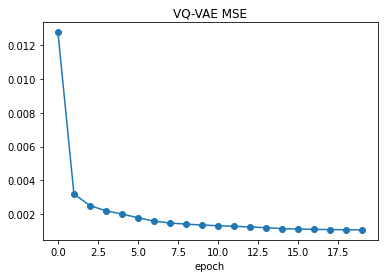

In [2]:
import matplotlib.pyplot as plt
f = plt.figure() #  (default: [6.4, 4.8]) Width, height in inches.
ax = f.add_subplot(1,1,1) # 1行2列の1つめ
ax.plot(train_recon_error, marker="o")
# ax.set_yscale('')
ax.set_title('VQ-VAE MSE')
ax.set_xlabel('epoch')
plt.savefig('mse.png')